## FE-630 Final Project

### Advisor: Papa Momar Ndiaye

### Student: Riley Heiman

### Date: Fall 2022

In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
pip install yfinance


### Step 1: Get data from Fama French Web and calculate:


$$ cov(R_t) = B \Omega B^T + D $$

Where: 

- $B$ = 

- $\Omega$ = covariance of factors

- $D = $ Diagonal matrix 




In [ ]:
#Gather etf data
def gather_etf_data():

  ticker_list = ['FXE','EWJ','GLD','QQQ','SPY','SHV', 'DBA','USO','XBI','ILF','EPP','FEZ']
  etf_returns = yf.download(ticker_list,'2000-3-1')['Adj Close'].pct_change(1).dropna()
  return etf_returns

print(gather_etf_data()) 

[*********************100%***********************]  12 of 12 completed
                 DBA       EPP       EWJ       FEZ       FXE       GLD  \
Date                                                                     
2007-01-12  0.079681  0.015441  0.012978  0.007280  0.001937  0.025400   
2007-01-16 -0.040590  0.004667  0.003559 -0.002595  0.000155 -0.003217   
2007-01-17 -0.005000  0.002643  0.000000 -0.005946  0.000850  0.010812   
2007-01-18  0.005025  0.001917 -0.000709 -0.003177  0.002626 -0.006066   
2007-01-19 -0.005769  0.016821  0.007097  0.012376  0.000308  0.011886   
...              ...       ...       ...       ...       ...       ...   
2022-12-06 -0.007082  0.000000 -0.003104 -0.003774 -0.001447  0.002737   
2022-12-07  0.001019 -0.005955  0.002931  0.002273  0.003934  0.009039   
2022-12-08  0.000509  0.013594  0.006210  0.003779  0.004434  0.000842   
2022-12-09 -0.005086  0.000227  0.003086 -0.003765 -0.002567  0.003544   
2022-12-12  0.008691  0.002045 -0.000181 

In [ ]:
# Gather fama french data
def gather_fama_data():
  url = 'https://github.com/Riley25/FE-630/blob/main/3-factor-model-data_FE-630.xlsx?raw=true'

  fama_data = pd.read_excel(url)
  fama_data['Date'] = pd.to_datetime(fama_data["Date"],format="%Y%m%d")
  fama_data = fama_data.set_index('Date')
  return fama_data

In [ ]:
def gather_all_data():
  etf_returns = gather_etf_data()
  fama_data = gather_fama_data()

  # joined data sets
  def annual_to_daily_rates(rates): return (1+np.array(rates))**(1/365)-1

  df = pd.concat([etf_returns, fama_data], axis=1)
  df = df.reset_index()
  df = df[df['Date']>"2007-03-01"]
  df = df[df['Date']<"2022-10-31"]
  df = df.set_index('Date')
  df['RF'] = annual_to_daily_rates(df['RF'])
  
  return df

In [ ]:
sample_df =gather_all_data()
print(sample_df.shape)


[*********************100%***********************]  12 of 12 completed
(3945, 16)


### Step 2: 

Write some functions 

- Two objective functions

In [ ]:
# CAPM to get betas
def lm_values_single(df, xvar, yvar):
    if xvar==yvar: return 1
    from sklearn.linear_model import LinearRegression

    plot_mdf3 = df[[xvar, yvar]]
    plot_mdf3 = plot_mdf3[plot_mdf3[xvar].notnull()]
    plot_mdf3 = plot_mdf3[plot_mdf3[yvar].notnull()]

    x = np.array(plot_mdf3[xvar]).reshape((-1,1))
    y = np.array(plot_mdf3[yvar])

    # BUILD THE MODEL
    model = LinearRegression()
    model.fit(x,y)
    
    r_sq = model.score(x,y)

    y_pred = model.predict(x)
    y_pred = model.intercept_ + model.coef_ * x
    
    residuals = (y - y_pred)
    std_residuals = np.var(residuals)

    r2 = round(r_sq,2)
    m = round(float(model.coef_), 3)
    b = round(float(model.intercept_) , 2)

    return m

In [ ]:
# Fama French Betas
def lm_values_multi(df, xvar, yvar):
    
    from sklearn.linear_model import LinearRegression
    l = len(xvar)
    vars_to_keep = []
    vars_to_keep.extend(xvar); vars_to_keep.extend(yvar)

    subset_mdf3 = df[vars_to_keep]

    x = np.array(subset_mdf3[xvar])
    y = np.array(subset_mdf3[yvar])

    # BUILD THE MODEL
    model = LinearRegression()
    model.fit(x,y)
    
    r_sq = model.score(x,y)

    y_pred = model.predict(x)
    y_pred = model.intercept_ + model.coef_ * x
    
    residuals = (y - y_pred)
    std_residuals = np.var(residuals)

    r2 = (r_sq)
    BETA = ((model.coef_))
    ALPHA = (float(model.intercept_) )

    return(ALPHA, BETA, std_residuals)

In [ ]:
sample_df = pd.DataFrame({'QQQ': [.01, 1, .025], 
                         'x1': [0.1, 0.45,0.17],
                         'x2':[.35,.45,.001]})

In [ ]:
lm_values_multi(sample_df, ['x1', 'x2'], ['QQQ'])  

(-0.43226480836236936, array([[2.68687573, 0.49593496]]), 0.15274381771987658)

In [ ]:
ticker_list = ['FXE','EWJ','GLD','QQQ','SPY','SHV','DBA','USO','XBI','ILF','EPP','FEZ']

# Build Matrices
def build_BETA_matrix(df): 
  return np.array([lm_values_multi(df,['Mkt-RF','SMB','HML'],[stock])[1][0] for stock in ticker_list])

def get_OMEGA(df): return df[['Mkt-RF','SMB','HML']].cov()

def get_DIAGONAL(df): return np.diag([lm_values_multi(df,['Mkt-RF','SMB','HML'],[stock])[2] for stock in ticker_list])

def get_SIGMA(beta,omega,diag): return np.matmul(np.matmul(beta, omega),beta.T)+diag
  
def get_RHO(df): return [lm_values_multi(df,['Mkt-RF','SMB','HML'],[stock])[0] for stock in ticker_list]

def build_CAPM_matrix(df):
  capm = []
  for stock in ticker_list:
    capmi = lm_values_single(df,"SPY",stock)
    capm.append(capmi)
  return capm

In [ ]:
# Optimize Portfolio

def PORT(MATRIX_RETURNS, COVARIANCE_MATRIX, BETA_MATRIX ,LAMBDA = 0.0):
    from scipy.optimize import minimize 
    def objective(weights): 
        weights = np.array(weights)
        #print(weights)
        return( -1*MATRIX_RETURNS.T.dot( weights ) + LAMBDA*np.sqrt( weights.T.dot(COVARIANCE_MATRIX).dot(weights) ) )

    # The weights must sum up to one. 
    cons = ( {"type":"eq", "fun": lambda weights:np.array(np.sum(weights)-1)} ,      
             {"type":"ineq", "fun": lambda weights: np.array( [3.5 + np.sum(BETA_MATRIX*weights)]) } , 
             {"type":"ineq", "fun": lambda weights: np.array( [3.5 - np.sum(BETA_MATRIX*weights)]) } )

    #cons = ( {"type":"eq", "fun": lambda weights:np.array(np.sum(weights)-1)} )

    # Every weight must be between -2 and 2
    bounds = tuple( (-2, 2) for x in range(MATRIX_RETURNS.shape[0]) ) 
     
    guess = [0.1 for x in range(MATRIX_RETURNS.shape[0])]

    optimized_results = minimize(objective, guess, method = "SLSQP",  # Nelder-Mead
                                 bounds=bounds, constraints=cons)
    w = optimized_results.x
    return(w)  

In [ ]:
MATRIX_RETURNS = np.array([0.056782, 0.119096, 0.238250]).reshape(3,1)

BETA_MATRIX = np.array([.5, .45, -.25]).reshape(3,1)

COVARIANCE_MATRIX = np.array( [[3.41550211e-04, 7.85028502e-05, 8.01693547e-05],
                              [7.85028502e-05, 1.44469014e-04, 6.62561744e-05],
                              [8.01693547e-05, 6.62561744e-05, 1.68821444e-04]] ).reshape(3,3)

In [ ]:
w = PORT(MATRIX_RETURNS, COVARIANCE_MATRIX, BETA_MATRIX ,LAMBDA = 1.0)     

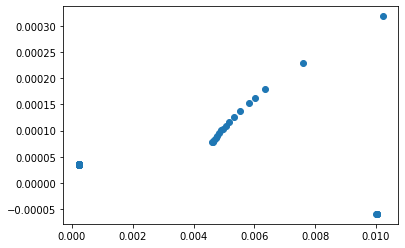

In [ ]:
import matplotlib.pyplot as plt

b = build_BETA_matrix(df)
o = get_OMEGA(df)
d = get_DIAGONAL(df)
s = np.array(get_SIGMA(b,o,d))
r = np.array(get_RHO(df))
c = np.array(build_CAPM_matrix(df))

port_risks = []
port_returns = []

for lambda_input in np.linspace(0,1,200):
  w = PORT(r,s,c,LAMBDA=lambda_input)
  port_return = r.T.dot(w)
  port_risk = (np.matmul(w.T,np.matmul(s,w)))**0.5 
  
  port_returns.append(port_return)
  port_risks.append(port_risk)

plt.scatter(port_risks,port_returns)

In [ ]:
from scipy.stats import skew,kurtosis, norm

sample_returns = [0.02,0.01,-0.04,0.06,-0.01,0.02,0,0,-0.02,0.01,-0.02,0,0,-0.01,0.01,-0.026]

def arithmetic_mean_returns(returns): return sum(returns)/len(returns)
def geometric_mean_returns(returns): return np.product(1+np.array(returns))**(1/len(returns))-1
def sharpe_ratio(returns,rf): return ((1+arithmetic_mean_returns(returns))**365-1-rf)/np.std(returns)
def skewness(returns): return skew(returns)
def stock_kurtosis(returns): return kurtosis(returns) # excess kurtosis
def min_return(returns): return np.min(returns)
def annual_volatility(returns): return np.std(returns) * (52)**0.5
def var_95(returns): return norm.ppf(0.05, arithmetic_mean_returns(returns), np.std(returns))
def emp_var_95(returns): return np.percentile(returns, 100 * 0.05)
def emp_cvar_95(returns): return np.nanmean(returns[returns < emp_var_95(returns)])
def get_daily_returns(returns): return [(np.array(returns)+1)**(1/5)-1]

sharpe_ratio(sample_returns,0.01)
arithmetic_mean_returns(sample_returns)
geometric_mean_returns(sample_returns)
skewness(sample_returns)
stock_kurtosis(sample_returns)
print(emp_var_95(sample_returns))
print(get_daily_returns(sample_returns))

-0.0295
[array([ 0.00396838,  0.00199205, -0.00813116,  0.01172195, -0.00200805,
        0.00396838,  0.        ,  0.        , -0.00403239,  0.00199205,
       -0.00403239,  0.        ,  0.        , -0.00200805,  0.00199205,
       -0.00525494])]


In [ ]:

def PORT_2(MATRIX_RETURNS, COVARIANCE_MATRIX, BETA_MATRIX , r, r_spy, LAMBDA = 0.0):

    def covar(r):
      df = pd.DataFrame(r)
      covariances = []
      for ticker in ticker_list:
        cov = np.cov(np.array(df[ticker]),np.array(df['SPY']))[0][1]
        covariances.append(cov)
      return covariances

    from scipy.optimize import minimize
    def objective(weights): 
        weights = np.array(weights) 
        port_return = np.matmul(r ,weights)
        a = np.matmul(np.matmul(weights.T,(COVARIANCE_MATRIX)),weights)
        covariance = covar(r)
        b = np.matmul(weights.T, covariance )
        c = np.var(r_spy)
        if a - b + c < 0:
          print("NEGATIVE TEV","A", a,"B",b,"C",c,"TEV",a-b+c)
        TEV = np.sqrt(a  - b +  c)
    
        return( (-1*MATRIX_RETURNS.T.dot( weights ) / TEV ) + LAMBDA*np.sqrt( weights.T.dot(COVARIANCE_MATRIX).dot(weights) ) )

    # The weights must sum up to one. 
    cons = ( {"type":"eq", "fun": lambda weights:np.array(np.sum(weights)-1)} ,      
             {"type":"ineq", "fun": lambda weights: np.array( [1.0 + np.sum(BETA_MATRIX*weights)]) } , 
             {"type":"ineq", "fun": lambda weights: np.array( [2.0 - np.sum(BETA_MATRIX*weights)]) } )

    #cons = ( {"type":"eq", "fun": lambda weights:np.array(np.sum(weights)-1)} )

    # Every weight must be between -2 and 2
    bounds = tuple( (-2, 2) for x in range(MATRIX_RETURNS.shape[0]) ) 
     
    guess = [0.01 for x in range(MATRIX_RETURNS.shape[0])]

    optimized_results = minimize(objective, guess, method = "SLSQP",  # Nelder-Mead
                                 bounds=bounds, constraints=cons)
    w = optimized_results.x
    return(w)  



In [ ]:
# run for entire space
def get_weights(df,lambda_input=0.5):
  b = build_BETA_matrix(df)
  o = get_OMEGA(df)
  d = get_DIAGONAL(df)
  s = np.array(get_SIGMA(b,o,d))
  r = np.array(get_RHO(df))
  c = np.array(build_CAPM_matrix(df))

  w1 = PORT(r,s,c,LAMBDA=lambda_input)
  w2 = PORT_2(r,s,c,df[ticker_list],df['SPY'],LAMBDA = lambda_input)

  return w1, w2

In [ ]:
def subset_gatherdata(df, start_date, end_date, ticker_list, just_ETF = True ):
    date_included = df.reset_index()
    sub_df = date_included[ (date_included['Date'] <= str(end_date)) &  (date_included['Date'] >= str(start_date))]
    sub_df = sub_df.set_index('Date')
    if just_ETF == True: sub_df = sub_df[ticker_list]
    return(sub_df)

In [ ]:
import datetime as dt

def portfolio_get_returns(returns,weights):
  ticker_list = ['FXE','EWJ','GLD','QQQ','SPY','SHV','DBA','USO','XBI','ILF','EPP','FEZ']
  df = pd.DataFrame(returns)
  rets = [np.product(1+np.array(df[ticker]))-1 for ticker in ticker_list]
  return np.matmul(np.array(weights).T,rets)

def main(window_size=180):
  ticker_list = ['FXE','EWJ','GLD','QQQ','SPY','SHV','DBA','USO','XBI','ILF','EPP','FEZ']
  df = gather_all_data()
  t = dt.date(2007,3,1)
  return_series_1 = []
  return_series_2 = []
  x_series = []

  while True:
    print(t)
    x_series.append(t)

    t1 = t-dt.timedelta(window_size)
    t2 = t-dt.timedelta(1)
    t3 = t+dt.timedelta(5)

    sub = subset_gatherdata(df,t1,t2,ticker_list,False).dropna()
    w1,w2 = get_weights(sub,0.3)
    returns = subset_gatherdata(df,t,t3,ticker_list,True)
    p1 = portfolio_get_returns(returns,w1)
    p2 = portfolio_get_returns(returns,w2)
    return_series_1.append(p1)
    return_series_2.append(p2)

    if t > dt.date(2022,10,31):
      print('breaking') 
      break
    t += dt.timedelta(days=7)

  return pd.DataFrame({"Date":x_series, "Returns_1":return_series_1,"Returns_2":return_series_2})

df = main()
df.to_csv("run11.csv")
from google.colab import files
files.download("run11.csv")

# run 1: lambda = 0.5, window = 40
# run 2: lambda = 0.5, window = 90
# run 3: lambda = 0.5, window = 180

# run 4: lambda = 0.7, window = 40
# run 5: lambda = 0.7, window = 90
# run 6: lambda = 0.7, window = 180

# run 7: spy data

# run 8: lambda = 0.5, window = 40 again with weights

# run 9: lambda = 0.3, window = 40
# run 10: lambda = 0.3, window = 90
# run 11: lambda = 0.3, window = 180

# run 12: lambda = 0.1, window = 40
# run 13: lambda = 0.1, window = 90
# run 14: lambda = 0.1, window = 180


[*********************100%***********************]  12 of 12 completed
2007-03-01
2007-03-08
2007-03-15
2007-03-22
2007-03-29
2007-04-05
2007-04-12
2007-04-19
2007-04-26
2007-05-03
2007-05-10
2007-05-17
2007-05-24
2007-05-31
2007-06-07
2007-06-14
2007-06-21
2007-06-28
2007-07-05
2007-07-12
2007-07-19
2007-07-26
2007-08-02
2007-08-09
2007-08-16
2007-08-23
2007-08-30
2007-09-06
2007-09-13
2007-09-20
2007-09-27
2007-10-04
2007-10-11
2007-10-18
2007-10-25
2007-11-01
2007-11-08
2007-11-15
2007-11-22
2007-11-29
2007-12-06
2007-12-13
2007-12-20
2007-12-27
2008-01-03
2008-01-10
2008-01-17
2008-01-24
2008-01-31
2008-02-07
2008-02-14
2008-02-21
2008-02-28
2008-03-06
2008-03-13
2008-03-20
2008-03-27
2008-04-03
2008-04-10
2008-04-17
2008-04-24
2008-05-01
2008-05-08
2008-05-15
2008-05-22
2008-05-29
2008-06-05
2008-06-12
2008-06-19
2008-06-26
2008-07-03
2008-07-10
2008-07-17
2008-07-24
2008-07-31
2008-08-07
2008-08-14
2008-08-21
2008-08-28
2008-09-04
2008-09-11
2008-09-18
2008-09-25
2008-10-02
2008-

In [ ]:
df = pd.DataFrame({"x":[1,2,3],"y":[1,4,9]})
df.to_csv("data.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Quuestions

$$ cov(\epsilon_i , \epsilon_j)= 
\left\{
\begin{array}{ll} 
     \sigma_i^2 \: when \: i =j  & \\
      0 \: otherwise
\end{array} 
\right.  $$ 

0.5377288128297139


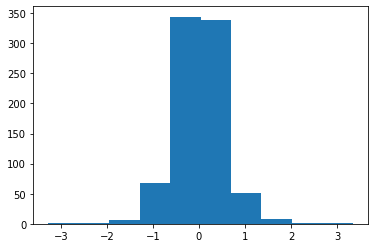

In [ ]:
c = np.array(a)-1
plt.hist(c)
print(np.std(c))

In [ ]:
np.cov([1,1,1], [1,1,1]) 

array([[0., 0.],
       [0., 0.]])